# Part 2 EDA

In [2]:
import pandas as pd
import numpy as np
import plotly
import matplotlib.pyplot as plt
import seaborn as sb


In [ ]:
# Import Metadata
metadata = pd.read_csv('Cleaned Data CSVs/weather_stations_list.csv')

metadata.head()

,station_id,name,latitude,longitude,elevation,country,provider
0,2979,Cap_ferrat,43.68333,7.32367,138,France,FR_METEOFRANCE
1,2978,Les_orres_fontaines,44.47567,6.55767,1895,France,FR_METEOFRANCE
2,2977,Broc,46.60966,7.10816,682,Switzerland,CH_METEOSWISS
3,2976,Mesocco,46.39560,9.23108,825,Switzerland,CH_METEOSWISS
4,2975,Dischingen_Eglingen,48.71340,10.44050,550,Germany,DE_DWD


: 

In [3]:
# Import Station Data 
station_data = pd.read_csv('Cleaned Data CSVs/monthly_snowpack.csv')

station_data.head()

,id,station_id,year,month,hnsum
0,371401,2249,1996,3,39.0
1,371402,2249,1997,1,99.0
2,371403,2249,1997,2,22.0
3,371404,2249,1997,3,7.0
4,371405,2249,1998,1,84.0


In [4]:
# station_data.describe()
station_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500100 entries, 0 to 1500099
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   id          1500100 non-null  int64  
 1   station_id  1500100 non-null  int64  
 2   year        1500100 non-null  int64  
 3   month       1500100 non-null  int64  
 4   hnsum       1027301 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 57.2 MB


In [5]:
# Drop Null Values
station_data = station_data.dropna()

station_data.describe(include='all')

,id,station_id,year,month,hnsum
count,1.027301e+06,1.027301e+06,1.027301e+06,1.027301e+06,1.027301e+06
mean,1.068072e+06,1.489530e+03,1.990848e+03,6.405561e+00,1.941337e+01
std,4.381786e+05,8.584716e+02,1.802231e+01,3.521692e+00,3.985992e+01
min,3.714010e+05,1.000000e+00,1.864000e+03,1.000000e+00,0.000000e+00
25%,6.808710e+05,7.560000e+02,1.980000e+03,3.000000e+00,0.000000e+00
50%,1.045491e+06,1.494000e+03,1.993000e+03,6.000000e+00,0.000000e+00
75%,1.404724e+06,2.235000e+03,2.004000e+03,1.000000e+01,2.100000e+01
max,1.871500e+06,2.979000e+03,2.020000e+03,1.200000e+01,8.270000e+02


In [37]:
station_data.head()

,id,station_id,year,month,hnsum
0,371401,2249,1996,3,39.0
1,371402,2249,1997,1,99.0
2,371403,2249,1997,2,22.0
3,371404,2249,1997,3,7.0
4,371405,2249,1998,1,84.0


In [ ]:
# Assess 'Winter Months' between November - April

station_data['winter'] = station_data['month'].isin([11, 12, 1, 2, 3, 4])

station_data.head()

,id,station_id,year,month,hnsum,winter
0,371401,2249,1996,3,39.0,True
1,371402,2249,1997,1,99.0,True
2,371403,2249,1997,2,22.0,True
3,371404,2249,1997,3,7.0,True
4,371405,2249,1998,1,84.0,True


In [42]:

station_data.shape

(1027301, 6)

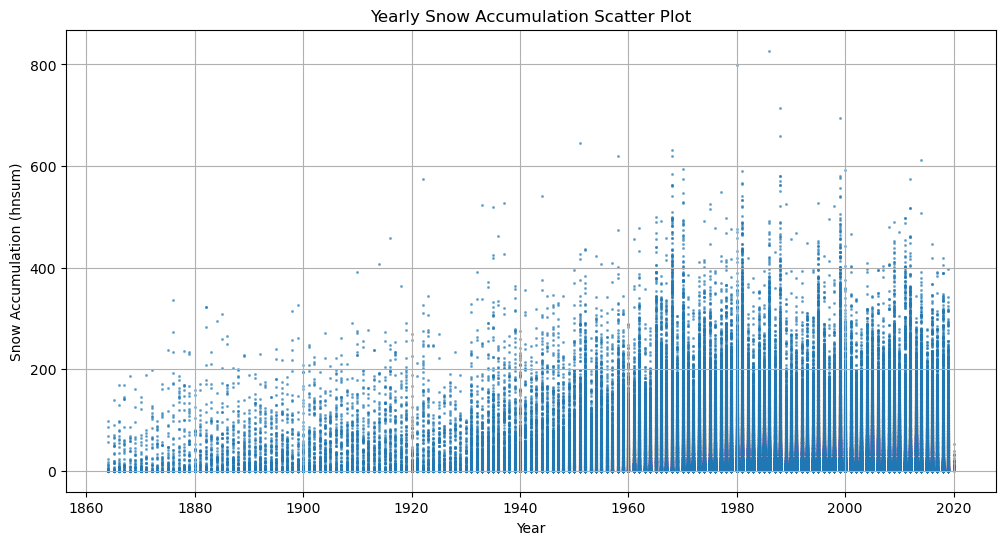

In [40]:
# Create Variables
mean_snow = station_data['hnsum']
year = station_data['year']

# Create a scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(year, mean_snow, alpha=0.5, s=1.4)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Snow Accumulation (hnsum)')
plt.title('Yearly Snow Accumulation Scatter Plot')
plt.grid(True)
plt.show()

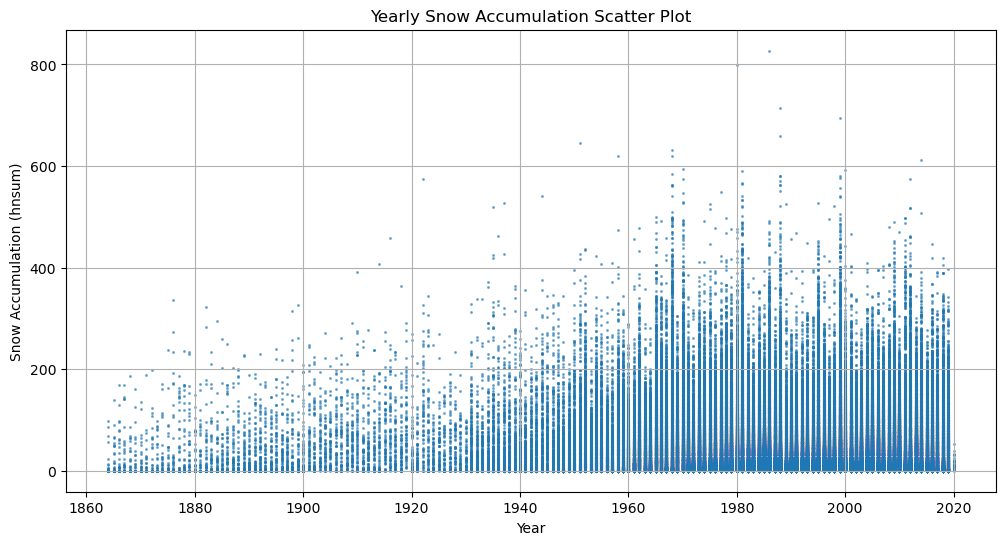

In [41]:
# Create Variables
mean_snow = station_data[station_data['winter'] == True]['hnsum']
year = station_data[station_data['winter'] == True]['year']

# Create a scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(year, mean_snow, alpha=0.5, s=1.4)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Snow Accumulation (hnsum)')
plt.title('Yearly Snow Accumulation Scatter Plot')
plt.grid(True)
plt.show()

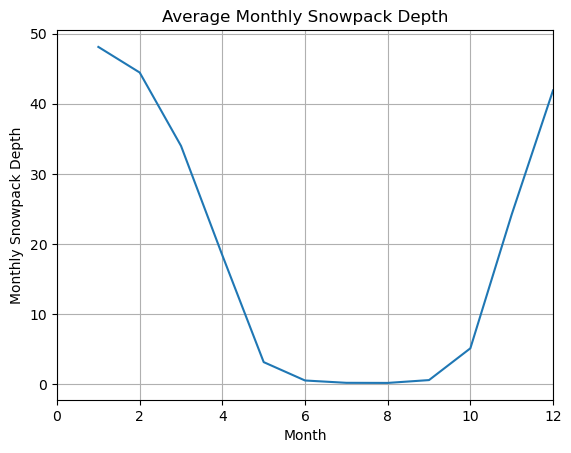

In [34]:
monthly_avg = station_data.groupby('month')['hnsum'].mean().reset_index()

plt.plot(monthly_avg['month'], monthly_avg['hnsum'])

plt.xlabel('Month')
plt.xlim(0,12)
plt.ylabel('Monthly Snowpack Depth')
plt.title('Average Monthly Snowpack Depth')
plt.grid(True)

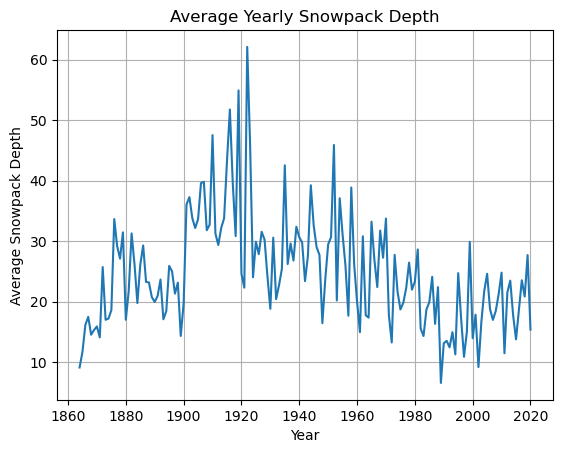

In [25]:
yearly_avg = station_data.groupby('year')['hnsum'].mean().reset_index()
plt.plot(yearly_avg['year'], yearly_avg['hnsum'])

plt.xlabel('Year')
plt.ylabel('Average Snowpack Depth')
plt.title('Average Yearly Snowpack Depth')
plt.grid(True)


In [36]:
yearly_avg = station_data[station_data['month'] in ([10,11,12,1,2,3,4])].groupby('year')['hnsum'].mean().reset_index()
plt.plot(yearly_avg['year'], yearly_avg['hnsum'])

plt.xlabel('Year')
plt.ylabel('Average Snowpack Depth')
plt.title('Average Yearly Snowpack Depth')
plt.grid(True)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().